In [1]:
%matplotlib inline
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import seaborn as sn

plt.style.use("ggplot")

In [2]:
# Connect to Nivabase
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# Compare 1000 Lakes data in RESA and Aquamonitor

"Final" (haha) comparison of data in RESA and AM following cleaning and updates made in notebook 01b.

## 1. Stations

The 1000 Lakes survey has project ID 12433 in AM. The aim here is to compare values in RESA and AM for all samples and parameters at these sites from the beginning of August 2019 to the end of the year.

In [3]:
# Get stations from AM
am_stns = nivapy.da.select_ndb_project_stations([12433], eng, drop_dups=True)
am_stns.rename({"station_id": "am_id"}, inplace=True, axis=1)

# Get RESA IDs for AM stations
bind_stns = ",".join("(1, %d)" % i for i in am_stns["am_id"].unique())
sql = (
    "SELECT station_id as am_id, "
    "  local_pk as resa_id "
    " FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND (1, station_id) in (%s)" % bind_stns
)
stn_link = pd.read_sql(sql, eng)

# Join
stn_df = pd.merge(am_stns, stn_link, how="left", on="am_id")

print(len(stn_df), "stations in the project")

stn_df.head()

1003 stations in the project


,am_id,station_code,station_name,station_type,longitude,latitude,resa_id
0,26070,221-1-2,Langtjern,Innsjø,11.850274,59.808643,10
1,26071,101-2-7,Hokksjøen,Innsjø,11.563586,59.004423,9
2,26072,402-2-13,Sætertjern,Innsjø,12.446711,60.060222,11
3,26073,419-1-25,Mjøgsjøen,Innsjø,11.842186,60.328578,12
4,26074,425-2-2,Kottern,Innsjø,12.517008,60.590729,13


## 2. AM data

In [4]:
# Read latest AM data
am_xls = r"../../../1000_Lakes_AM_Export_2020-06-11_Project_Only.xlsx"
am_wc = pd.read_excel(am_xls, sheet_name="WaterChemistry")
print(len(am_wc))
am_wc.head()

1001


,project_id,project_name,station_id,station_code,station_name,sample_date,excel_date,depth1,depth2,Al,...,Pb,pH,PO4-P,SiO2,SO4,Temp,TOC,TOTN,TOTP,Zn
0,12433,Nasjonal Innsjøundersøkelse 2019,26472,1001-1-55,Skeivatnet,30.10.2019 00.00.00,2019-10-30,0,0,300,...,1.1,5.37,< 1,2.51,1.32,8.2,9.2,390,5,8.3
1,12433,Nasjonal Innsjøundersøkelse 2019,71862,1001-2-204,Vassvann,29.10.2019 00.00.00,2019-10-29,0,0,130,...,0.18,6.34,< 1,2.8,4.13,8.5,6.8,380,6,8.4
2,12433,Nasjonal Innsjøundersøkelse 2019,26474,1002-1-62,Vråvatn,30.10.2019 00.00.00,2019-10-30,0,0,220,...,0.5,6.63,10,2.24,2.19,7.6,7.6,520,15,5.4
3,12433,Nasjonal Innsjøundersøkelse 2019,26475,1003-1-16,HOH 130,30.10.2019 00.00.00,2019-10-30,0,0,160,...,0.41,5.43,< 1,1.87,1.69,8.1,3.6,280,3,3.2
4,12433,Nasjonal Innsjøundersøkelse 2019,26476,1003-1-18,HOH 14,30.10.2019 00.00.00,2019-10-30,0,0,110,...,0.33,5.44,< 1,1.1,2.45,8.6,3.3,270,3,4.4


## 2. Parameters in RESA

In [5]:
# Time period of interest
st_dt = "2019-08-01"
end_dt = "2019-12-31"

# Get available parameters
re_pars = nivapy.da.select_resa_station_parameters(
    stn_df["resa_id"].unique(), st_dt, end_dt, eng
)

36 parameters available for the selected stations and dates.


## 3. Water chemistry

In [6]:
# Get RESA water chemistry
re_wc, re_dups = nivapy.da.select_resa_water_chemistry(
    stn_df["resa_id"].unique(), re_pars, st_dt, end_dt, eng, drop_dups=True
)

re_wc.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,ALK_mmol/l,Al/Il_µg/l,Al/R_µg/l,Al_µg/l,...,Pb_µg/l,SO4_mg/l,SiO2_mg SiO2/l,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TURB860_FNU,Temp_oC,Zn_µg/l,pH_
,,,,,,,,,,,,,,,,,,,,,
0,9,101-2-7,Hokksjøen,2019-10-25,0,0,0.030,220.0,280.0,430.0,...,1.10,1.89,3.73,24.2,580.0,10.0,NaN,NaN,7.1,4.67
1,10,221-1-2,Langtjern,2019-10-25,0,0,0.054,130.0,150.0,280.0,...,1.20,0.61,3.72,20.0,370.0,11.0,NaN,NaN,5.3,5.09
2,11,402-2-13,Sætertjern,2019-10-25,0,0,0.057,130.0,200.0,340.0,...,0.71,1.10,4.06,20.3,400.0,9.0,NaN,NaN,3.3,5.22
3,12,419-1-25,Mjøgsjøen,2019-10-25,0,0,0.030,120.0,140.0,280.0,...,1.20,0.58,3.36,25.8,410.0,10.0,NaN,NaN,6.7,4.39
4,13,425-2-2,Kottern,2019-10-25,0,0,0.039,120.0,160.0,290.0,...,0.71,0.78,4.89,16.8,370.0,11.0,NaN,NaN,4.3,4.96


In [7]:
# Show duplicates from RESA
re_dups.head(10)

,station_id,station_code,station_name,sample_date,depth1,depth2,parameter_name,unit,flag1,value,entered_date
26446,10,221-1-2,Langtjern,2019-10-25,0,0,TOTN,µg/l N,None,250.0,2019-12-10 09:30:02
26469,10,221-1-2,Langtjern,2019-10-25,0,0,TOTN,µg/l N,None,370.0,2020-06-12 11:08:31
26480,11,402-2-13,Sætertjern,2019-10-25,0,0,TOTN,µg/l N,None,260.0,2019-11-28 10:30:02
26503,11,402-2-13,Sætertjern,2019-10-25,0,0,TOTN,µg/l N,None,400.0,2020-06-12 11:08:37
25197,14,432-1-26,Måsabutjørna,2019-10-24,0,0,TOTN,µg/l N,None,83.0,2020-03-03 16:30:05
25220,14,432-1-26,Måsabutjørna,2019-10-24,0,0,TOTN,µg/l N,None,120.0,2020-06-12 11:08:49
25231,15,436-1-7,HOH 1066,2019-10-24,0,0,TOTN,µg/l N,None,480.0,2019-12-16 11:30:02
25254,15,436-1-7,HOH 1066,2019-10-24,0,0,TOTN,µg/l N,None,940.0,2020-06-12 11:08:53
25265,16,438-1-13,Brennvoltjørna,2019-10-24,0,0,TOTN,µg/l N,None,140.0,2020-02-10 15:30:02
25288,16,438-1-13,Brennvoltjørna,2019-10-24,0,0,TOTN,µg/l N,None,230.0,2020-06-12 11:08:54


The duplicates in RESA are mostly the TOTN reanalyses, as expected.

In [8]:
# Restructure
am_wc.drop(
    ["project_id", "project_name", "station_id", "station_name", "sample_date"],
    inplace=True,
    axis=1,
)
am_wc.rename({"excel_date": "sample_date"}, inplace=True, axis=1)
re_wc.drop(["station_id", "station_name"], inplace=True, axis=1)

am_wc = am_wc.melt(
    id_vars=["station_code", "sample_date", "depth1", "depth2"], value_name="am_value"
)
re_wc = re_wc.melt(
    id_vars=["station_code", "sample_date", "depth1", "depth2"], value_name="resa_value"
)
re_wc['variable'], _ = re_wc['variable'].str.split('_', 1).str

wc_df = pd.merge(
    am_wc,
    re_wc,
    how="inner",
    on=["station_code", "sample_date", "depth1", "depth2", "variable"],
)

wc_df['am_value'] = wc_df['am_value'].astype(str).str.replace('<', '')
wc_df['am_value'] = wc_df['am_value'].str.replace('>', '')
wc_df['am_value'] = wc_df['am_value'].str.replace(',', '.').astype(float)

wc_df.loc[wc_df['variable'] == 'F', 'am_value'] = wc_df.loc[wc_df['variable'] == 'F', 'am_value'] * 1000

wc_df

,station_code,sample_date,depth1,depth2,variable,am_value,resa_value
0,1001-1-55,2019-10-30,0,0,Al,300.00,300.00
1,1001-2-204,2019-10-29,0,0,Al,130.00,130.00
2,1002-1-62,2019-10-30,0,0,Al,220.00,220.00
3,1003-1-16,2019-10-30,0,0,Al,160.00,160.00
4,1003-1-18,2019-10-30,0,0,Al,110.00,110.00
...,...,...,...,...,...,...,...
34029,941-3-12,2019-10-23,0,0,Zn,1.10,1.10
34030,941-3-13,2019-10-23,0,0,Zn,0.83,0.83
34031,941-3-18,2019-09-30,0,0,Zn,0.71,0.71
34032,941-3-5,2019-09-30,0,0,Zn,0.90,0.90


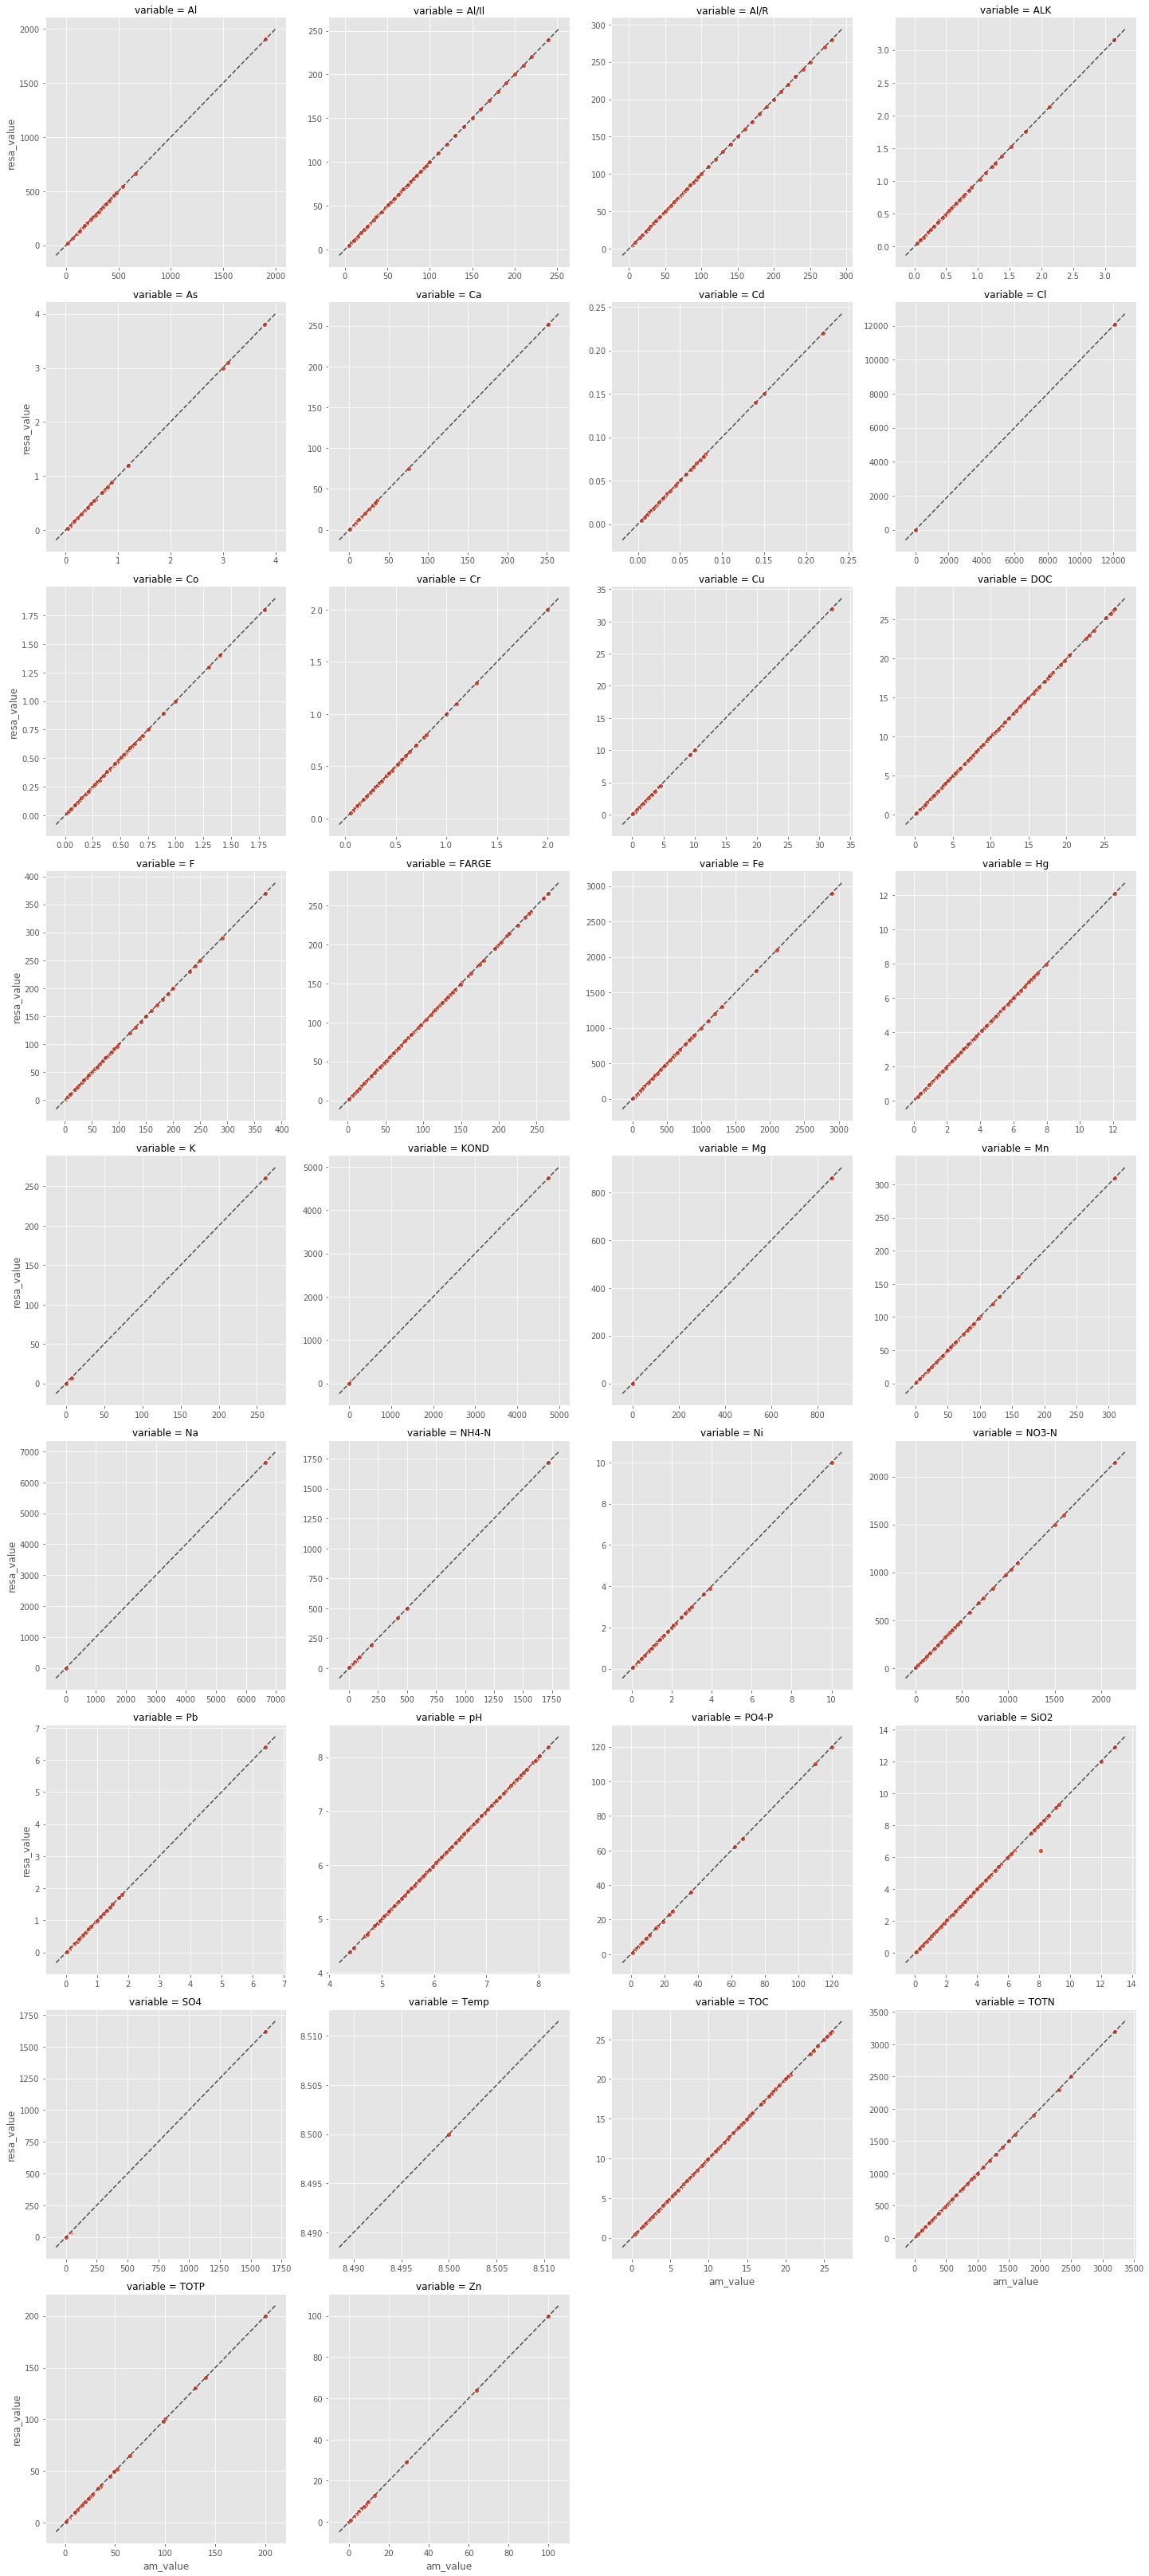

In [9]:
# Compare RESA to AM
g = sn.relplot(
    data=wc_df,
    x="am_value",
    y="resa_value",
    col="variable",
    col_wrap=4,
    facet_kws={"sharey": False, "sharex": False},
)

for ax in g.axes:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

plt.savefig(r"../output/compare_resa_am.png", dpi=200)

In [10]:
wc_df.groupby("variable").count()[['am_value', 'resa_value']]

,am_value,resa_value
variable,,
ALK,1001,1001
Al,1001,1001
Al/Il,1000,1000
Al/R,1000,1000
As,1001,1001
Ca,1001,1001
Cd,1001,1001
Cl,1001,1001
Co,1001,1001
